## Simple text processing and neural networks.
This  assigments consists of five parts:

1. Simple feature generation for text data (Bag of Words)
2. Text classification using generated features and simple neural network.
3. Text classsification using more complex features (TF-IDF).
4. Text classsification using pretrained word vectors.
5. Visualization of pretrained vectors.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Prohibited Comment Classification
### Part I: BoW and Logistic Regression
*This part of assigment is based on YSDA NLP course materials.*

![img](https://github.com/yandexdataschool/nlp_course/raw/master/resources/banhammer.jpg)

__In this part__ you will build an algorithm that classifies social media comments into normal or toxic.
Like in many real-world cases, you only have a small (10^3) dataset of hand-labeled examples to work with. We'll tackle this problem using both classical nlp methods and embedding-based approach.

In [2]:
import pandas as pd
data = pd.read_csv("comments.tsv", sep='\t')

texts = data['comment_text'].values
target = data['should_ban'].values
data[50::200]

,should_ban,comment_text
50,0,"""Those who're in advantageous positions are th..."
250,1,Fartsalot56 says f**k you motherclucker!!
450,1,"Are you a fool? \n\nI am sorry, but you seem t..."
650,1,I AM NOT A VANDAL!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
850,0,Citing sources\n\nCheck out the Wikipedia:Citi...


In [3]:
from sklearn.model_selection import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.5, random_state=42)

__Note:__ it is generally a good idea to split data into train/test before anything is done to them.

It guards you against possible data leakage in the preprocessing stage. For example, should you decide to select words present in obscene tweets as features, you should only count those words over the training set. Otherwise your algoritm can cheat evaluation.

### Preprocessing and tokenization

Comments contain raw text with punctuation, upper/lowercase letters and even newline symbols.

To simplify all further steps, we'll split text into space-separated tokens using one of nltk tokenizers.

Generally, library `nltk` [link](https://www.nltk.org) is widely used in NLP. It is not necessary in here, but mentioned to intoduce it to you.

In [4]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

text = 'How to be a grown-up at work: replace "I don\'t want to do that" with "Ok, great!".'
print("before:", text,)
print("after:", preprocess(text),)

before: How to be a grown-up at work: replace "I don't want to do that" with "Ok, great!".
after: how to be a grown-up at work : replace " i don't want to do that " with " ok , great ! " .


In [5]:
# task: preprocess each comment in train and test

texts_train = #<YOUR CODE>
texts_test = #<YOUR CODE>

In [6]:
# Small check that everything is done properly
assert texts_train[5] ==  'who cares anymore . they attack with impunity .'
assert texts_test[89] == 'hey todds ! quick q ? why are you so gay'
assert len(texts_test) == len(y_test)

### Solving it: bag of words

![img](http://www.novuslight.com/uploads/n/BagofWords.jpg)

One traditional approach to such problem is to use bag of words features:
1. build a vocabulary of frequent words (use train data only)
2. for each training sample, count the number of times a word occurs in it (for each word in vocabulary).
3. consider this count a feature for some classifier

__Note:__ in practice, you can compute such features using sklearn. __Please don't do that in the current assignment, though.__
* `from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer`

In [7]:
# task: find up to k most frequent tokens in texts_train,
# sort them by number of occurences (highest first)
k = min(10000, len(set(' '.join(texts_train).split())))

from collections import Counter
all_texts = " ".join(texts_train).split()
#<YOUR CODE>

bow_vocabulary = #<YOUR CODE>

print('example features:', sorted(bow_vocabulary)[::100])

token_to_idx = {token: idx for idx, token in enumerate(bow_vocabulary)}

example features: ['!', '12:20', '300', '_', 'adorned', 'alternative', 'archive', 'average', 'benkner', 'bout', 'came', 'chest', 'combined', 'consumers', 'cricket', 'decisions', 'dickheads', 'domestic', 'eductaion', 'essentially', 'faggot', 'firms', 'frustrated', 'goal', 'hanibal', 'hip-hop', 'identified', 'infoboxes', 'issue', 'kindergarten', 'lets', 'lot', "mclaren's", 'moderator', 'naturally', 'noticeable', 'opposing', 'pdf', 'plant', 'pretoria', 'punctuation', 'rebels', 'repetative', 'riadh', 'schulz', 'shes', 'slit', 'spoof', 'stupid', 't', 'theoretical', 'topic', 'uglyness', 'userspace', 'wanted', 'wikieditor', 'year', 'ீ']


In [8]:
def text_to_bow(text):
    """ convert text string to an array of token counts. Use bow_vocabulary. """
    #<YOUR CODE>
    
    #return np.array(<...>, 'float32')

In [9]:
X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

In [10]:
# Small check that everything is done properly
k_max = len(set(' '.join(texts_train).split()))
assert X_train_bow.shape == (len(texts_train), min(k, k_max))
assert X_test_bow.shape == (len(texts_test), min(k, k_max))
assert np.all(X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in  texts_train[5:10]]))
assert len(bow_vocabulary) <= min(k, k_max)
assert X_train_bow[6, bow_vocabulary.index('.')] == texts_train[6].split().count('.')

Let's train simple logistic regression and look at accuracy and ROC-AUC score. The function below plots the model ROC curve (generally, it's bad idea to use outer scope variables, but now we just want to save some space).

In [11]:
from sklearn.metrics import roc_auc_score, roc_curve
def get_roc_auc(model, plot_title, X_train, y_train, X_test, y_test, pytorch=False):
    plt.figure()
    for name, X, y in [
        ('train', X_train, y_train),
        ('test ', X_test, y_test)
    ]:
        if pytorch:
            proba = np.array(model(torch.Tensor(X))[:, -1].detach())
        else:
            proba = model.predict_proba(X)[:, -1]
        auc = roc_auc_score(y, proba)
        plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

    plt.plot([0, 1], [0, 1], '--', color='black',)
    plt.legend(fontsize='large')
    plt.title(plot_title)
    plt.grid()

In [12]:
from sklearn.linear_model import LogisticRegression
bow_model = # <YOUR CODE>

/Users/nexes/miniconda3/envs/py3_research/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


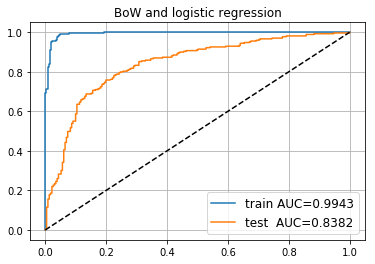

In [13]:
get_roc_auc(bow_model, 'BoW and logistic regression', X_train_bow, y_train, X_test_bow, y_test)

Try to vary the number of tokens `k` and check how the model performance changes. Show it on a plot.

#### Part II: Simple neural network using PyTorch.
Let's build very simple neural network and compare it to the sklearn Logistic Regression.

In [14]:
import sys
print(sys.version_info)

import torch
print(torch.__version__)
import numpy as np

sys.version_info(major=3, minor=6, micro=7, releaselevel='final', serial=0)
1.1.0.post2


In [15]:
from torch import nn

In [16]:
X_test_bow.shape

(500, 5722)

In [17]:
# create a network that stacks layers on top of each other
model = nn.Sequential()

# Add the only layer for logistic regression
# <YOUR CODE>


# add sigmoid activation for probability
# note: layer names must be unique
# <YOUR CODE>

In [18]:
# create dummy data with 3 samples
x = torch.tensor(X_train_bow[:3], dtype=torch.float32)
y = torch.tensor(y_train[:3], dtype=torch.float32)

# compute outputs given inputs, both are variables
y_predicted = model(x)[:, 0]

y_predicted # display what we've got

tensor([0.5027, 0.4862, 0.4927], grad_fn=<SelectBackward>)

In [21]:
crossentropy = nn.functional.binary_cross_entropy(y_predicted, y, reduction='none')

loss = crossentropy.mean(dim=0, keepdim=True)

assert tuple(crossentropy.size()) == (3,), "Crossentropy must be a vector with element per sample"
assert tuple(loss.size()) == (1,), "Loss must be scalar. Did you forget the mean/sum?"
assert loss.data.numpy()[0] > 0, "Crossentropy must non-negative, zero only for perfect prediction"
assert loss.data.numpy()[0] <= np.log(3), "Loss is too large even for untrained model. Please double-check it."

In [25]:
opt = torch.optim.Adam(model.parameters(), lr=0.01)


In [26]:
history = []

for i in range(100):
    
    ix = np.random.randint(0, len(X_train_bow), 64)
    x_batch = torch.tensor(X_train_bow[ix], dtype=torch.float32)
    y_batch = torch.tensor(y_train[ix], dtype=torch.float32)
    
    # predict probabilities
    ### YOUR CODE
    
    assert y_predicted.dim() == 1, "did you forget to select first column with [:, 0]"
    
    # compute loss, just like before
    ### YOUR CODE
    
    loss.backward()      # add new gradients
    opt.step()           # change weights
    opt.zero_grad()      # clear gradients
    
    history.append(loss.data.numpy())
    
    if i % 10 == 0:
        print("step #%i | mean loss = %.3f" % (i, np.mean(history[-10:])))

step #0 | mean loss = 0.677
step #10 | mean loss = 0.541
step #20 | mean loss = 0.401
step #30 | mean loss = 0.298
step #40 | mean loss = 0.245
step #50 | mean loss = 0.206
step #60 | mean loss = 0.173
step #70 | mean loss = 0.155
step #80 | mean loss = 0.137
step #90 | mean loss = 0.126


In [27]:
# use your model to predict classes (0 or 1) for all test samples
predicted_y_test = model(torch.tensor(X_test_bow, dtype=torch.float32))[:, 0]
predicted_y_test = np.array(predicted_y_test.detach())# > 0.5)
         
assert isinstance(predicted_y_test, np.ndarray), "please return np array, not %s" % type(predicted_y_test)
assert predicted_y_test.shape == y_test.shape, "please predict one class for each test sample"

accuracy = np.mean(predicted_y_test == (y_test>0.5))

print("Test accuracy: %.5f" % accuracy)
assert accuracy > 0.95, "try training longer"

print('Great job!')

AssertionError: please predict class indexes

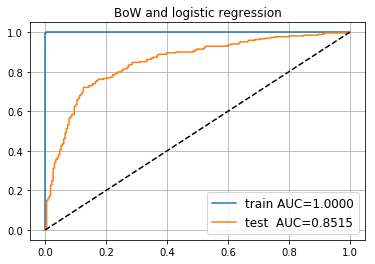

In [28]:
get_roc_auc(model, 'BoW and Neural Network (LR)', X_train_tfidf, y_train, X_test_tfidf, y_test, pytorch=True)

What's the difference? Try to build something more complex than Logistic Regression (if you haven't already).

In [29]:
# Your beautiful code here

### For the brave ones, Part III: implement TF-IDF features



Not all words are equally useful. One can prioritize rare words and downscale words like "and"/"or" by using __tf-idf features__. This abbreviation stands for __text frequency/inverse document frequence__ and means exactly that:

$$ feature_i = { Count(word_i \in x) \times { log {N \over Count(word_i \in D) + \alpha} }}, $$


where x is a single text, D is your dataset (a collection of texts), N is a total number of documents and $\alpha$ is a smoothing hyperparameter (typically 1). 
And $Count(word_i \in D)$ is the number of documents where $word_i$ appears.

It may also be a good idea to normalize each data sample after computing tf-idf features.

__Your task:__ implement tf-idf features, train a model and evaluate ROC curve. Compare it with basic BagOfWords model from above.

__If you are out of time, try to use sklearn/nltk builtin tf-idf vectorizers in your solution :)__ Otherwise you can still use 'em for debugging though.

In [32]:
from sklearn.preprocessing import StandardScaler

# <YOUR CODE HERE>


In [33]:
tfidf_model = LogisticRegression().fit(X_train_tfidf, y_train)


/Users/nexes/miniconda3/envs/py3_research/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


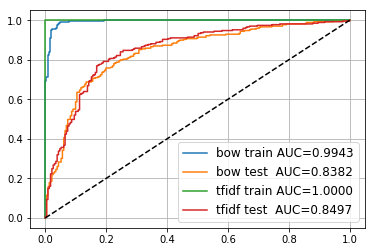

In [78]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('bow train', X_train_bow, y_train, bow_model),
    ('bow test ', X_test_bow, y_test, bow_model),
    ('tfidf train', X_train_tfidf, y_train, tfidf_model),
    ('tfidf test ', X_test_tfidf, y_test, tfidf_model),
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Blog post about implementing the TF-IDF features from scratch: https://triton.ml/blog/tf-idf-from-scratch

### Part IV: Solving it better: word vectors

Let's try another approach: instead of counting per-word frequencies, we shall map all words to pre-trained word vectors and average over them to get text features.

This should give us two key advantages: (1) we now have 10^2 features instead of 10^4 and (2) our model can generalize to word that are not in training dataset.

We begin with a standard approach with pre-trained word vectors. However, you may also try
* training embeddings from scratch on relevant (unlabeled) data
* multiplying word vectors by inverse word frequency in dataset (like tf-idf).
* concatenating several embeddings
    * call `gensim.downloader.info()['models'].keys()` to get a list of available models
* clusterizing words by their word-vectors and try bag of cluster_ids

__Note:__ loading pre-trained model may take a while. It's a perfect opportunity to refill your cup of tea/coffee and grab some extra cookies. Or binge-watch some tv series if you're slow on internet connection

In [97]:
import gensim.downloader 
embeddings = gensim.downloader.load("fasttext-wiki-news-subwords-300")

# If you're low on RAM or download speed, use "glove-wiki-gigaword-100" instead. Ignore all further asserts. 
# Warning: "glove-wiki-gigaword-100" usually show results ~ similar to TF-iDF on this corpus, it's fine.

[==================================================] 100.0% 958.5/958.4MB downloaded


/Users/nexes/miniconda3/envs/py3_research/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [99]:
def vectorize_sum(comment):
    """
    implement a function that converts preprocessed comment to a sum of token vectors
    """
    embedding_dim = embeddings.vectors.shape[1]
    features = np.zeros([embedding_dim], dtype='float32')
    features[:] = np.sum([embeddings[word] for word in comment.split() if word in embeddings], axis=0)
    
    return features

assert np.allclose(
    vectorize_sum("who cares anymore . they attack with impunity .")[::70],
    np.array([ 0.0108616 ,  0.0261663 ,  0.13855131, -0.18510573, -0.46380025])
)

In [100]:
X_train_wv = np.stack([vectorize_sum(text) for text in texts_train])
X_test_wv = np.stack([vectorize_sum(text) for text in texts_test])

/Users/nexes/miniconda3/envs/py3_research/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.929351936786881

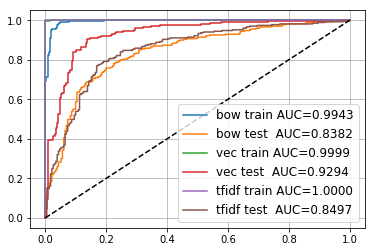

In [101]:
wv_model = LogisticRegression().fit(X_train_wv, y_train)

for name, X, y, model in [
    ('bow train', X_train_bow, y_train, bow_model),
    ('bow test ', X_test_bow, y_test, bow_model),
    ('vec train', X_train_wv, y_train, wv_model),
    ('vec test ', X_test_wv, y_test, wv_model),
    ('tfidf train', X_train_tfidf, y_train, tfidf_model),
    ('tfidf test ', X_test_tfidf, y_test, tfidf_model),
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

roc_auc_score(y_test, wv_model.predict_proba(X_test_wv)[:, 1])

In [102]:
# Your beautiful code here

### Part V: Visualizing word vectors.

In [103]:
embeddings.most_similar(positive=["coder", "money"], negative=["brain"])

[('coders', 0.54557204246521),
 ('moneyman', 0.5144726037979126),
 ('money-', 0.5120781660079956),
 ('mone', 0.48399990797042847),
 ('money--', 0.4752413034439087),
 ('code', 0.4714774489402771),
 ('moneymen', 0.4712296426296234),
 ('money.', 0.47117751836776733),
 ('moneywise', 0.4707126021385193),
 ('money--and', 0.46807125210762024)]

In [104]:
words = sorted(embeddings.vocab.keys(), 
               key=lambda word: embeddings.vocab[word].count,
               reverse=True)[:1000]

print(words[::100])

[',', 'than', 'last', 'find', 'building', 'provided', 'region', 'adding', 'young', 'developed']


In [105]:
word_vectors = embeddings[words]

In [106]:
from sklearn.manifold import TSNE

# map word vectors onto 2d plane with TSNE. hint: use verbose=100 to see what it's doing.
# normalize them as just lke with pca


word_tsne = TSNE(verbose=100).fit_transform(word_vectors)
word_tsne -= word_tsne.mean(0)
word_tsne /= word_tsne.std(0)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.007s...
[t-SNE] Computed neighbors for 1000 samples in 0.668s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.274060
[t-SNE] Computed conditional probabilities in 0.030s
[t-SNE] Iteration 50: error = 80.0148773, gradient norm = 0.2950084 (50 iterations in 11.658s)
[t-SNE] Iteration 100: error = 79.8979568, gradient norm = 0.3011067 (50 iterations in 4.408s)
[t-SNE] Iteration 150: error = 83.1839218, gradient norm = 0.2837323 (50 iterations in 4.243s)
[t-SNE] Iteration 200: error = 82.7045364, gradient norm = 0.2725400 (50 iterations in 3.867s)
[t-SNE] Iteration 250: error = 81.5591507, gradient norm = 0.2700786 (50 iterations in 3.925s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.559151
[t-SNE] Iteration 300: error = 1.5417404, gradient norm = 0.0037132 (50 iterations in 3.119s)
[t-SNE] Iteration 350: error = 1.4033940, gradient norm = 0.0007

In [107]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook
output_notebook()

def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    if isinstance(color, str): color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: pl.show(fig)
    return fig

Loading BokehJS ...

In [108]:
draw_vectors(word_tsne[:, 0], word_tsne[:, 1], color='green', token=words)

Figure(id='1112', ...)